# Kaggle Digit Recognition

This is one of the problem proposed on Kaggle: handwritten digit recognition using the MNIST data. We use scikit-learn.

In [1]:
import pandas as pd
from time import clock

We begin by loading the both the training and the testing data.

In [2]:
# Read training data
start = clock()

train_frame = pd.read_csv('data/train.csv')
label = train_frame['label'].values
train = train_frame.iloc[:,1:].values

print('Loaded {:d} train entries in {:.0f} seconds.'.format(len(train), clock() - start))

# Train on fewer entries
# label = label[0::10]
# train = train[0::10]

# Read test data 
start = clock()

test_frame = pd.read_csv('data/test.csv')
test = test_frame.values

print('Loaded {:d} test entries in {:.0f} seconds.'.format(len(test), clock() - start))

Loaded 42000 train entries in 2 seconds.
Loaded 28000 test entries in 1 seconds.


To make sure that we load the data correctly, we can take a random digit in the training set to visualize.

Displayed train entry 37135 labelled 5.


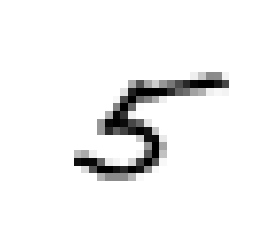

In [3]:
# Select a random entry

from random import randint  

i = randint(0,len(train)-1)
print("Displayed train entry {:d} labelled {:d}.".format(i, label[i]))

# Plot using matplotlib

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline  
    
train_square = train.reshape(-1,28,28)
plt.imshow(train_square[i], cmap=cm.binary)
plt.axis('off')
plt.show()

# Select Classifier

A first demonstration can be quickly done with a random forest.

In [4]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 100)

In [5]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators = 100)

Another choice is to first preprocess the data with PCA, say, and then pipeline this with SVC.

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC

n_comp = 35
pca = PCA(n_components = n_comp, whiten = True)
clf = make_pipeline(pca, SVC())

## Validate, Train, Extrapolate
We can use cross-validation to get an idea of how well the classifier generalizes.

In [7]:
from sklearn.model_selection import cross_val_score
start = clock()

scores = cross_val_score(clf, train, label, n_jobs = 6)

print("Performed {:d}-fold cross validation in {:.0f} seconds with accuracy {:0.4f} +/- {:0.4f}.".format(
    len(scores), clock() - start, scores.mean(), scores.std()))

Performed 3-fold cross validation in 1 seconds with accuracy 0.9777 +/- 0.0014.


Result
- Random Forest with 1000 estimator performed 3-fold cross validation in 655 seconds with accuracy 0.9645 +/- 0.0022. 
- ExtraTrees performed 3-fold cross validation in 49 seconds with accuracy 0.9656 +/- 0.0006.
- PCA+SVM performed 3-fold cross validation in 132 seconds with accuracy 0.9777 +/- 0.0013.

We are now ready to fit the classifier to the training data, predict/extrapolate to the test data, and save the results.

In [8]:
# Fit training data

start = clock()
clf.fit(train, label)
print("Fitted training data in {:.0f} seconds.".format(clock() - start))

# Extrapolate to test data

start = clock()
predict = clf.predict(test)
print("Extrapolated to test data in {:.0f} seconds.".format(clock() - start))

# Save results

test_frame['ImageId'] = range(1,len(test)+1)
test_frame['Label'] = predict
test_frame.to_csv('predict.csv', columns = ('ImageId', 'Label'), index = None)

Fitted training data in 43 seconds.
Extrapolated to test data in 19 seconds.


If we used PCA+SVC, PCA can tell us how much of the variance is explained.

In [9]:
n_comp = 35
variance = sum(clf.named_steps['pca'].explained_variance_ratio_)
print("PCA uses {:d} components explaining {:.0%} of the variance.".format(n_comp, variance))

PCA uses 35 components explaining 76% of the variance.


## Improvements
We can attempt to select SVC's parameters by optimizing with grid search.

In [ ]:
# Transform data
from sklearn.decomposition import PCA

n_comp = 35
pca = PCA(n_components = n_comp, whiten = True)

start = clock()
pca.fit(train)
train_transformed = pca.transform(train)

print("Transformed data in {:.0f} seconds using {:d} components explaining {:.0%} of the variance.".format(
        clock() - start, n_comp, sum(pca.explained_variance_ratio_)))

# Select classifier
from sklearn.svm import SVC

algo = 'rbf'
tol = 0.01
clf = SVC(kernel = algo, tol = tol, shrinking = True)

# Search on fewer entries
label_few = label[0::10]
train_few = train_transformed[0::10]

# Parameter space to search for SVC
from numpy import logspace
params = [{'C': logspace(-1, 3), 'gamma': logspace(-4, -1)}]
    
# Run exhaustive grid search
from sklearn.model_selection import GridSearchCV
start = clock()

gs = GridSearchCV(estimator = clf, param_grid = params, n_jobs = 6)
gs.fit(train_few, label_few)

print("Parameter optimi zed {} yielding {:.4f} in {:.0f} seconds.".format(
        gs.best_params_, gs.best_score_, clock() - start))

Here are some choices of parameters for SVC that seem to work reasonably well.
- C = 4.2919342601287758 and gamma = 0.028117686979742307 gives 0.8857 in 6 seconds.
- C = 1.3894954943731375 and gamma = 0.042919342601287783 gives 0.9502 in 27 seconds.

Scikit-learn also has neural networks available.

In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(alpha = 1e-4, hidden_layer_sizes = (10, 10, 10), random_state = 1)

start = clock()
scores = cross_val_score(clf, train, label, n_jobs = 6)
print("Performed {:d}-fold cross validation in {:.0f} seconds with accuracy {:0.4f} +/- {:0.4f}.".format(
    len(scores), clock() - start, scores.mean(), scores.std()))